# Basic Poisson equation

This example is implemented in the Python file <a href="poisson_basic.py" target="_blank">poisson_basic.py</a> and it illustrates how to:

- Solve a linear partial differential equation;
- Create a mesh for a disk domain;
- Define a `FunctionSpace`;
- Create and apply Dirichlet boundary conditions;
- Plot the solution;
- Use `errornorm` to compare results with the exact solution;
- Evaluate the value of the function at an arbitrary location.

## Equation and problem definition

The Poisson equation on a unit disk ($R=1$) with  Dirichlet boundary conditions:

<div align="center">    
    $\begin{array}{r c c l}
    \nabla^2 u &=& -1 & \text{in } \Omega,\\
    u &=& 0 & \text{on } \Gamma.\\
    \end{array}$    
</div>
&emsp;
<div align="center">    
    <img src="figs/poisson_basic_domain.png" style="width: 200px;"/>
</div>

The exact solution in Cartesian coordinates is
$$u({\bf x})\equiv u(x,y)=\frac{1}{4} \left(1-x^2-y^2\right).$$

### Weak formulation of the problem

In FEniCS, we are solving the weak form of the PDE
$$\int_\Omega d{\bf x} \ (\nabla^2 u + 1) \ v = 0,$$
where $v$ is an arbitrary *test function* that evaluates to $0$ on the boundary points with prescribed values (Dirichlet boundary conditions). Using integration by parts, the above equation can be rewritten as 
$$\int_\Omega d{\bf x} \ (-\nabla u \cdot \nabla v + v) = 0.$$


## Implementation

In order to use the FEniCS package we need to import relevant libraries:

In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

Define a circular domain and generate a triangular mesh. The cell size is approximately equal to the diameter of the domain divided by the resolution ($N$). 

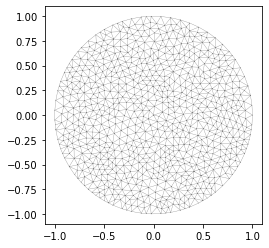

In [2]:
# Create mesh
R = 1. # radius
N = 20 # mesh resolution
domain = Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh,linewidth=0.3)
plt.show()

Next, we define the `FunctionSpace` that lives on the mesh.

In [3]:
#define function space
degreeElements = 1
FS = FunctionSpace(mesh, 'Lagrange', degreeElements)

In this example, we use linear *Lagrange* elements. Higher order elements can be used by changing the value of the `degreeElements`.  The list of finite element types that are supported in FEniCS is available here: <a href="https://fenicsproject.org/docs/dolfin/2017.2.0/python/programmers-reference/functions/functionspace/FunctionSpace.html" target="_blank">click this link</a>.

To impose Dirichlet boundary conditions on the `FunctionSpace`, we have to define a function that returns a boolean value: `True` if the given point $\bf x$ lies on the Dirichlet boundary and `False`
otherwise. The argument `on_boundary` is `True` if $\bf x$ is on the physical boundary
of the mesh. Note that the boundary function will be called for every discrete point
in the mesh, which means that we may define boundaries also inside the physical domain.

In [4]:
#impose Dirichlet boundary conditions
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(FS, Constant(0.), boundary)

Define function $u(\bf x)$ and test function $v(\bf x)$.

In [5]:
#define function u and test function v
u = Function(FS)
v = TestFunction(FS)

The weak formulation of the problem$$\int_\Omega d{\bf x} \ (-\nabla u \cdot \nabla v + v) = 0,$$
where `dx` describes the integration over the domain $\Omega$

In [6]:
# weak formulation of the problem
Res = -dot(grad(u), grad(v))*dx + v*dx

Solve the problem using the Dirichlet boundary conditions `bc` and store the solution in the function `u`.

In [7]:
# solve the problem
solve(Res == 0, u, bc)

<div class="alert alert-block alert-info">
    Note that the `solve` function can be used to solve both linear and non-linear problems. The default solver is using the <a href="https://en.wikipedia.org/wiki/Newton%27s_method" target="_blank">Newton-Raphson method</a>. Consult with the <a href="https://fenicsproject.org/documentation/" target="_blank"> FEniCS tutorial</a> for other solver options.
</div>

The solution $u({\bf x})$ can be plotted with the `plot` option, which uses the `matplotlib` package.

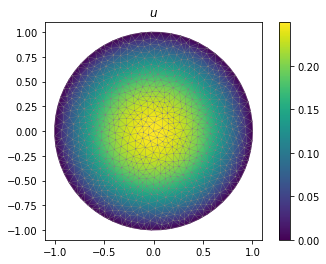

In [8]:
# plot solution
c = plot(u,mode='color',title='$u$')
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

The accuracy of the obtained solution $u({\bf x})$ can be compared against the exact solution
$u({\bf x})=\frac{1}{4} \left(1-x^2-y^2\right)$ by calculating the $L^2$ norm of the difference:

In [9]:
# exact solution
uExact=Expression('(1-x[0]*x[0]-x[1]*x[1])/4',degree=2)

# Compute error (L2 norm)
error_L2 = errornorm(uExact, u, 'L2')
print("Error = ",error_L2)

Error =  0.0010054862645973131


The `Expression` is using the C++ syntax to define functions, where `x[0]` and `x[1]` refer to the $x$ and $y$ coordinates, respectively, and the `degree` argument specifies the order of polynomial functions used to interpolate the expression on mesh elements. 

Function can be evaluated at an arbitrary point on the physical domain:

In [10]:
# evaluate function at several points
print("u(0,0) = ",u(0,0))
print("u(0.5,0.5) = ",u(0.5,0.5))

u(0,0) =  0.2497371456650515
u(0.5,0.5) =  0.12449260452913821


<div class="alert alert-block alert-danger">
Note that function cannot be evaluated outside the physical domain
</div>

In [11]:
print("u(2,0) = ",u(2,0))

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to evaluate function at point.
*** Reason:  The point is not inside the domain. Consider calling "Function::set_allow_extrapolation(true)" on this Function to allow extrapolation.
*** Where:   This error was encountered inside Function.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


<div class="alert alert-block alert-warning">
Be careful with points $x$ on the boundary $\Gamma$, because they may lie outside the discretized domain
</div>

In [12]:
print("u(1,0) = ",u(1,0))
print("u(0,1) = ",u(0,1))

u(1,0) =  0.0


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to evaluate function at point.
*** Reason:  The point is not inside the domain. Consider calling "Function::set_allow_extrapolation(true)" on this Function to allow extrapolation.
*** Where:   This error was encountered inside Function.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


Plot the value of function $u(x,0)$ along the $x$ coordinate axis using the `matplotlib` functions.

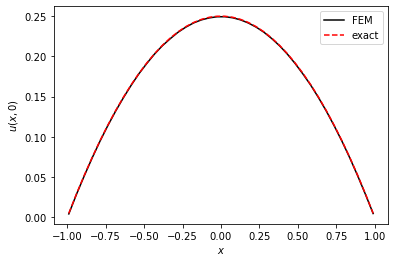

In [13]:
# plot solution
tol=1e-2;
x=np.linspace(-1+tol,1-tol,40)
points = [(x_, 0) for x_ in x]
u_line = np.array([u(point) for point in points])
plt.plot(x,u_line,'k-')
plt.plot(x,(1-x*x)/4,'r--')
plt.xlabel('$x$')
plt.ylabel('$u(x,0)$')
plt.legend(['FEM','exact'])
plt.show()

## Complete code

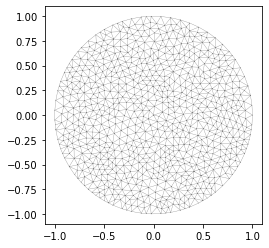

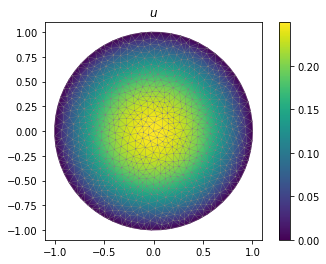

Error =  0.0010054862645973131
u(0,0) =  0.2497371456650515
u(0.5,0.5) =  0.12449260452913821
u(1,0) =  0.0


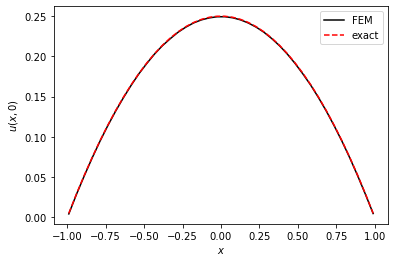

In [14]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

# Create mesh
R = 1. # radius
N = 20 # mesh resolution
domain = Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh,linewidth=0.3)
plt.show()

#define function space
degreeElements = 1
FS = FunctionSpace(mesh, 'Lagrange', degreeElements)

#impose Dirichlet boundary conditions
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(FS, Constant(0.), boundary)

#define function u and test function v
u = Function(FS)
v = TestFunction(FS)

# weak formulation of the problem
Res = -dot(grad(u), grad(v))*dx + v*dx

# solve the problem
solve(Res == 0, u, bc)

# plot solution
c = plot(u,mode='color',title='$u$')
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

# exact solution
uExact=Expression('(1-x[0]*x[0]-x[1]*x[1])/4',degree=2)

# Compute error (L2 norm)
error_L2 = errornorm(uExact, u, 'L2')
print("Error = ",error_L2)

# evaluate function at several points
print("u(0,0) = ",u(0,0))
print("u(0.5,0.5) = ",u(0.5,0.5))
#print("u(2,0) = ",u(2,0)) #point outside domain
print("u(1,0) = ",u(1,0))
# print("u(0,1) = ",u(0,1)) #point outside the discretized domain


# plot solution
tol=1e-2;
x=np.linspace(-1+tol,1-tol,40)
points = [(x_, 0) for x_ in x]
u_line = np.array([u(point) for point in points])
plt.plot(x,u_line,'k-')
plt.plot(x,(1-x*x)/4,'r--')
plt.xlabel('$x$')
plt.ylabel('$u(x,0)$')
plt.legend(['FEM','exact'])
plt.show()